#### Import packages and define the namespace for the GPX schema

If you get an error here, you will have to add packages to your Python distribution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from scipy.interpolate import interp1d
from PIL import Image, ExifTags
import datetime as dt
import pandas as pd
from lxml import etree
%matplotlib inline

# This is where the elements of the xml (gpx) file are defined
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}

#### All of the user input comes in this cell
TODO: add prompts for file/folder names, rather than editing here

In [2]:
# User input
# Enter name of .gpx file
logfile = 'G:\\2017-06-12_Duck_UAS\\gpx\\f5.gpx'

# Enter folder with associated images
imagefolder = 'G:\\2017-06-12_Duck_UAS\\jpeg\\f5'

# Enter time offset (seconds) so that imagetime + offset = log time
toff = -4.*3600. # The GPS data is being read in local time, the images are stamped with UTC

#### Define two functions to convert back and forth from Python datetime to Matlab datenum
Alternatively, I could learn how to use datetime


In [3]:
# routines to convert back and forth from datetime to Matlab datenum
def matlabdn2datetime(dn):
    """
    Input: Matlab datenum
    Returns: datetime   
    http://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python
    """
    day = dt.datetime.fromordinal(int(dn))
    dayfrac = dt.timedelta(days=dn%1) - dt.timedelta(days = 366)
    return day + dayfrac

def datetime2matlabdn(dtn):
    """
    Input: datetime
    Returns: Matlab datenum  
    http://stackoverflow.com/questions/8776414/python-datetime-to-matlab-datenum
    """
    mdn = dtn + dt.timedelta(days = 366)
    frac_seconds = (dtn-dt.datetime(dtn.year,dtn.month,dtn.day,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
    frac_microseconds = dtn.microsecond / (24.0 * 60.0 * 60.0 * 1000000.0)
    return mdn.toordinal() + frac_seconds + frac_microseconds

# examples
dtn=dt.datetime(2012, 2, 13, 6, 56, 2, 619000)
dn1=datetime2matlabdn(dtn)
dtn2 = matlabdn2datetime(dn1)
dn2 =datetime2matlabdn(dtn2)
print(dtn2,dn1,dn2)
print(dtn+dt.timedelta(minutes=5.))

2012-02-13 06:56:02.618997 734912.2889192014 734912.2889192014
2012-02-13 07:01:02.619000


### Parse the  .gpx file written by MissionPlanner, making arrays of time (in Matlab datenum representation)
...and the other stuff we want to use

[ 36.1810293 -75.7552479] 36.1810293 -75.7552479
(4860, 2)
2017-06-12 14:23:18 2017-06-12 14:40:03 736858.599514 736858.611146 (4860,)
-0.71 (4860,)
(4860, 0)
-0.24 (4860,)
(4860, 0)
course: 0.0 (4860,)
(4860, 0)
roll: 0.0 (4860,)
(4860, 0)
pitch: 0.0 (4860,)
(4860, 0)
mode: Loiter (4860,)
(4860, 0)


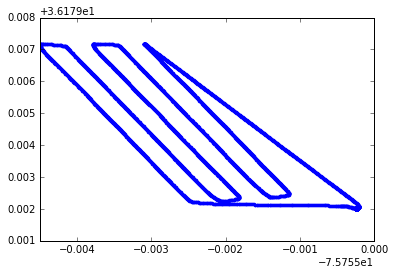

2017-06-12 14:23:18, 736858.5995138889, 36.1810293, -75.7552479, -0.71, -0.24, 0.0, 0.0, 0.0, Loiter
2017-06-12 14:23:18, 736858.5995138889, 36.1810294, -75.7552479, -0.7, -0.23, 340.7037, -1.265236, 2.383145, Loiter
2017-06-12 14:29:58, 736858.6041435185, 36.1810294, -75.755248, -0.7, -0.23, 340.6925, -1.266573, 2.377564, Loiter
2017-06-12 14:29:58, 736858.6041435185, 36.1810294, -75.7552479, -0.68, -0.21, 340.6851, -1.264506, 2.378118, Loiter
2017-06-12 14:29:58, 736858.6041435185, 36.1810295, -75.755248, -0.68, -0.21, 340.6866, -1.264782, 2.371143, Loiter
2017-06-12 14:29:59, 736858.6041550926, 36.1810295, -75.7552479, -0.67, -0.2, 340.6675, -1.27157, 2.368215, Loiter
2017-06-12 14:29:59, 736858.6041550926, 36.1810296, -75.755248, -0.67, -0.2, 340.656, -1.26118, 2.370797, Loiter
2017-06-12 14:30:01, 736858.6041782408, 36.1810297, -75.755248, -0.63, -0.16, 340.6332, -1.258554, 2.370206, Loiter
2017-06-12 14:30:02, 736858.6041898148, 36.1810296, -75.7552479, -0.64, -0.17, 340.6247, -1

In [4]:
# Parse .gpx
tree = etree.parse(logfile)

# Extract componeents from the trackpoints (ignore the waypoints)
# latitude and longitude
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
lonlat = [e.values() for e in elist]
lonlat = np.array(lonlat,dtype="float")
lat = lonlat[:,0]
lon = lonlat[:,1]
#TODO Remove these extraneous print statements
print(lonlat[0],lat[0],lon[0])
print(np.shape(lonlat))

# extract time as datetime object, then convert to Matlab datenum
elist = tree.xpath('./def:trk//def:trkpt//def:time',namespaces=namespace)
fmt = '%Y-%m-%dT%H:%M:%S-04:00' #2017-05-04T14:14:12-04:00
time = [dt.datetime.strptime(e.text, fmt) for e in elist]
dn = np.zeros((len(lon)))
for i in range(len(time)):
   dn[i] = datetime2matlabdn(time[i])
print(time[0],time[-1],dn[0],dn[-1], np.shape(time))

# The same thing works for other elements in a trkpt
elist = tree.xpath('./def:trk//def:trkpt//def:ele',namespaces=namespace)
ele = np.array([float(e.text) for e in elist])
print(ele[0], np.shape(ele))
print(np.shape(elist))

elist = tree.xpath('./def:trk//def:trkpt//def:ele2',namespaces=namespace)
ele2 = np.array([float(e.text) for e in elist])
print(ele2[0], np.shape(ele2))
print(np.shape(elist))

elist = tree.xpath('./def:trk//def:trkpt//def:course',namespaces=namespace)
course = np.array([float(e.text) for e in elist])
print("course: {}".format(course[0]), np.shape(ele2))
print(np.shape(elist))

elist = tree.xpath('./def:trk//def:trkpt//def:roll',namespaces=namespace)
roll = np.array([float(e.text) for e in elist])
print("roll: {}".format(roll[0]), np.shape(ele2))
print(np.shape(elist))

elist = tree.xpath('./def:trk//def:trkpt//def:pitch',namespaces=namespace)
pitch = np.array([float(e.text) for e in elist])
print("pitch: {}".format(pitch[0]), np.shape(ele2))
print(np.shape(elist))

elist = tree.xpath('./def:trk//def:trkpt//def:mode',namespaces=namespace)
mode = [e.text for e in elist]
print("mode: {}".format(mode[0]), np.shape(ele2))
print(np.shape(elist))

#TODO - make sure all of those arrays are the same length

# make a bare-bones trackline plot
plt.plot(lonlat[:,1],lonlat[:,0],'.')
plt.show()

# print a few of the data extracted from .gpx file
for i in range(10):
    print("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format(time[i],dn[i],lonlat[i,0],lonlat[i,1],ele[i],ele2[i],course[i],roll[i],pitch[i],mode[i]))

# For each images, read time, add offset, get interpolated GPS info

#### Loop through all of the images, grab time, and interpolate time from other arrays

In [5]:
# get a list of image files
flist=[os.path.join(imagefolder,f) for f in os.listdir(imagefolder) if ( f.endswith('.jpg') or f.endswith('.JPG'))]
nfiles = len(flist)
print("Found {} images in {}.".format(nfiles,imagefolder))

Found 232 images in G:\2017-06-12_Duck_UAS\jpeg\f5.


In [6]:
# format for interpreting datetime
# TODO - figure out how to handle time zone
fmt = '%Y:%m:%d %H:%M:%S' #2017-05-04T14:14:12-04:00

img_name = [] # list of file names
img_dt = []   # array of datetime objs
img_dn = []   # array of Matlab times
for f in flist:
    # read the image time stamps and add the time correction toff
    t=dt.datetime.strptime(Image.open(f)._getexif()[36867], fmt)+\
        dt.timedelta(seconds=toff)
    img_name.append(copy.copy(f))
    img_dt.append(copy.copy(t))
    img_dn.append(copy.copy(datetime2matlabdn(t)))

# print first and last image name and times
print("{}, {}, {}".format(img_name[0],img_dt[0],img_dn[0]))
print("{}, {}, {}".format(img_name[-1],img_dt[-1],img_dn[-1]))
# print first and last times in .gpx file
print("{} from {} {} to {} {}".format(logfile,time[0],dn[0],time[-1],dn[-1]))

G:\2017-06-12_Duck_UAS\jpeg\f5\B0007951.JPG, 2017-06-12 14:32:17, 736858.6057523148
G:\2017-06-12_Duck_UAS\jpeg\f5\B0008182.JPG, 2017-06-12 14:39:59, 736858.611099537
G:\2017-06-12_Duck_UAS\gpx\f5.gpx from 2017-06-12 14:23:18 736858.5995138889 to 2017-06-12 14:40:03 736858.6111458334


In [7]:
# array for storing lat, lon, and elevation for each image
img_data = np.ones((3,len(img_name)))*np.NaN   
# combine .gpx data into one array
# TODO: the heading, pitch, and roll data could be included as well
data = np.zeros((3,(len(dn))))
data[0,:]=lat
data[1,:]=lon
data[2,:]=ele
print(np.shape(data),np.shape(dn))

(3, 4860) (4860,)


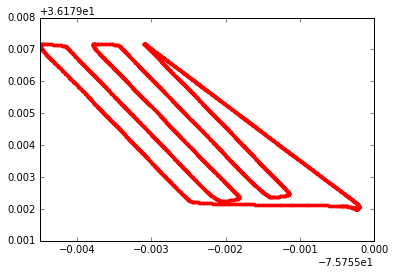

G:\2017-06-12_Duck_UAS\jpeg\f5\B0007951.JPG, 2017-06-12 14:32:17, 36.1810021, -75.7552389
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007952.JPG, 2017-06-12 14:32:19, 36.1810027, -75.7552392
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007953.JPG, 2017-06-12 14:32:21, 36.1810029, -75.7552396
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007954.JPG, 2017-06-12 14:32:23, 36.1810053, -75.7552365
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007955.JPG, 2017-06-12 14:32:25, 36.1810126, -75.7552302
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007956.JPG, 2017-06-12 14:32:27, 36.1810198, -75.7552268
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007957.JPG, 2017-06-12 14:32:29, 36.1810324, -75.7552217
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007958.JPG, 2017-06-12 14:32:31, 36.1810444, -75.7552176
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007959.JPG, 2017-06-12 14:32:33, 36.1810562, -75.7552108
G:\2017-06-12_Duck_UAS\jpeg\f5\B0007960.JPG, 2017-06-12 14:32:35, 36.1810618, -75.755208


In [9]:
# set up interpolation
set_interp = interp1d(dn, data, kind='linear')
# loop through the images and interpolate .gpx data 
for i in range(len(img_name)):
    if( img_dn[i]>=dn[0] and img_dn[i]<=dn[-1] ):
        # image time is within bounds of .gpx data
        img_data[:,i] = set_interp(img_dn[i])
    else:
        # image time is not within .gpx data
        print('No GPS data for {} {}'.format(img_name[i],img_dt[i]))

        
# make a bare-bones trackline and overlay image locations
plt.plot(lon[:],lat[:],'-')
plt.plot(data[1,:],data[0,:],'.r')
plt.show()
# print out file name, time, and data
# TODO - write a .csv file with columns in the in the correct order for Photoscan
for i in range(10):
    print("{}, {}, {}, {}".format(img_name[i],img_dt[i],img_data[0,i],img_data[1,i],img_data[2,i]))